# Description
This notebook creates a plot to illustrate different kinds of "bad fit" and how to diagnose them.

In [1]:
import numpy
from matplotlib import pyplot, cm
import scipy.stats

import calibr8
import plotting

In [2]:
class LinearModel(calibr8.BasePolynomialModelT):
    def __init__(self):
        super().__init__(
            independent_key="I", dependent_key="D", mu_degree=1, scale_degree=0
        )


class LogisticModel(calibr8.BaseAsymmetricLogisticT):
    def __init__(self):
        super().__init__(independent_key="I", dependent_key="D", scale_degree=1)


class Scenario:
    def __init__(self, x, y, title, model, truth):
        self.x = numpy.array(x)
        self.y = numpy.array(y)
        self.title = title
        if truth is None:
            T = len(model.theta_names)
            calibr8.fit_scipy(
                model,
                independent=self.x,
                dependent=self.y,
                theta_guess=truth or numpy.ones(T),
                theta_bounds=[(-50, 50)] * (T - 2) + [(0.001, 100)] * 2,
            )
        else:
            model.cal_independent = x
            model.cal_dependent = y
            model.theta_fitted = truth
        self.model = model
        self.plot_band = calibr8.plot_t_band

## Create scenarios by fitting the model to randomly generated data

In [3]:
N = 1000
x = numpy.linspace(0.01, 50, N)

A = Scenario(
    x,
    numpy.random.standard_t(df=8, size=N) * 0.2
    + calibr8.logistic(x, [0, 20, 30, 0.3]) * 0.7
    + 5,
    "location lack-of-fit",
    model=LinearModel(),
    truth=None,
)
B = Scenario(
    x,
    numpy.random.standard_t(df=8, size=N) * 0.2 * x / 2 + x * 0.7 + 5,
    "spread lack-of-fit",
    model=LinearModel(),
    truth=None,
)
C = Scenario(
    x,
    5 + x * 0.1 + numpy.random.lognormal(mean=1, sigma=0.3, size=N),
    "distribution lack-of-fit",
    model=LinearModel(),
    truth=None,
)

theta_true = [-5, 20, 25, 0.7, 0]
theta_spread = [0.5, 0.05, 8]
s0, s1, df = theta_spread
mu = calibr8.asymmetric_logistic(x, theta_true)
D = Scenario(
    x,
    mu + (s0 + s1 * mu) * numpy.random.standard_t(df=df, size=N),
    "perfect fit",
    model=LogisticModel(),
    truth=theta_true + theta_spread,
)

Parameter df (100.0) is close to its upper bound (100).
Fit of LinearModel has failed:
      fun: 647.4948771092336
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00034106,  0.00843556,  0.00013642, -0.01373338])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 495
      nit: 56
     njev: 99
   status: 0
  success: True
        x: array([ 19.84325826,   0.12633364,   0.45823948, 100.        ])


## Create one plot with all scenarios

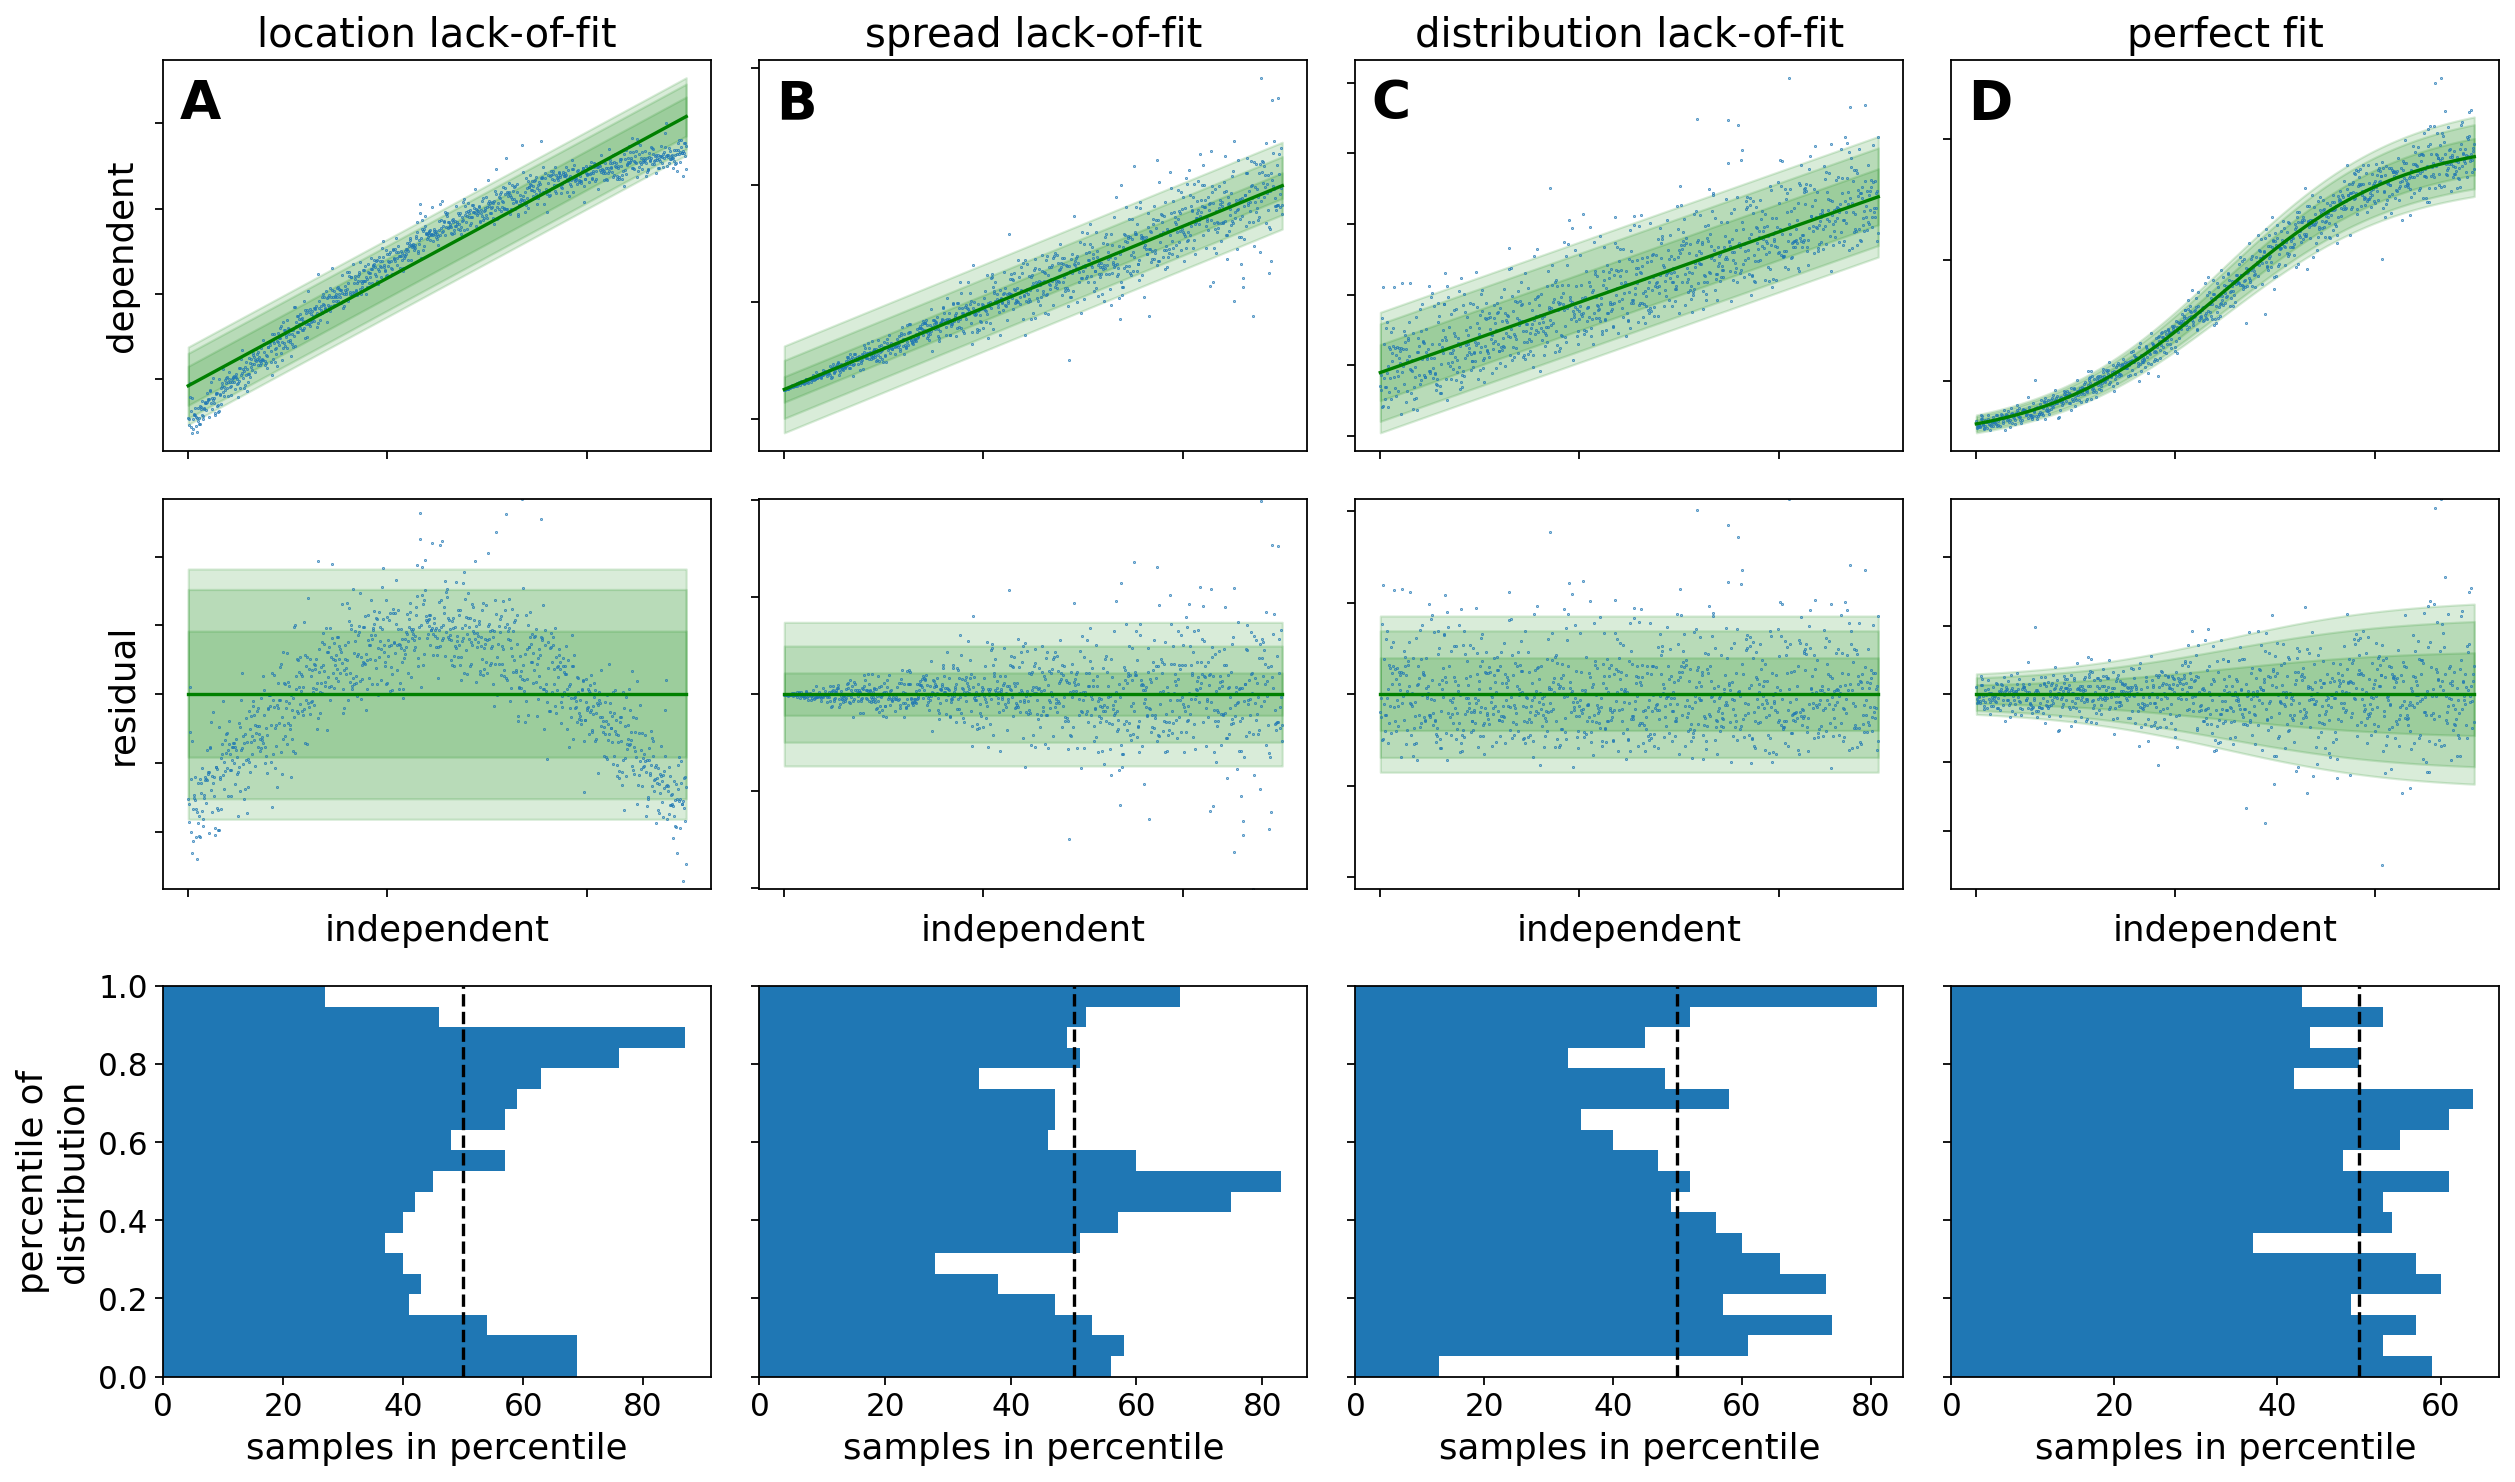

In [4]:
fheight = 10
fwidth = 16
fig, axs = pyplot.subplots(dpi=160, ncols=4, nrows=3, figsize=(fwidth, fheight))

S = 0.1
for c, X in enumerate([A, B, C, D]):
    axs[0, c].set_title(X.title)

    x_dense = numpy.linspace(X.x.min(), X.x.max(), 300)
    mu, scale, df = X.model.predict_dependent(x_dense)
    calibr8.plot_t_band(axs[0, c], x_dense, mu, scale, df)
    axs[0, c].scatter(X.x, X.y, s=S)
    axs[0, c].set_yticklabels([])
    axs[0, c].set_xticklabels([])

    x_dense = numpy.linspace(X.x.min(), X.x.max(), len(X.x))
    mu, scale, df = X.model.predict_dependent(x_dense)
    calibr8.plot_t_band(axs[1, c], X.x, numpy.zeros_like(X.x), scale, df)
    res = X.y - mu
    axs[1, c].scatter(X.x, res, s=S)
    axs[1, c].set_yticklabels([])
    axs[1, c].set_xticklabels([])
    axs[1, c].set_ylim(-numpy.abs(res).max(), numpy.abs(res).max())
    axs[1, c].set_xlabel("independent")
    if c == 0:
        axs[0, c].set_ylabel("dependent")
        axs[1, c].set_ylabel("residual")

    cdf_eval = scipy.stats.t.cdf(
        x=X.y,
        loc=mu,
        scale=scale,
        df=df,
    )
    bins = 20
    axs[2, c].hist(
        cdf_eval,
        bins=numpy.linspace(0, 1, bins),
        density=False,
        orientation="horizontal",
    )
    axs[2, c].set_ylim(0, 1)
    if c > 0:
        axs[2, c].set_yticklabels([])
    axs[2, c].set_xlabel("samples in percentile")
    axs[2, c].axvline(N / bins, linestyle="--", color="black")
axs[2, 0].set_ylabel("percentile of\ndistribution")

fig.tight_layout()
hspace = axs[0, 1].get_position().x0 - axs[0, 0].get_position().x1
ytop1 = axs[0, 0].get_position().y0 - hspace * (fwidth / fheight)
for ax in axs[1, :]:
    bb = ax.get_position()
    ax.set_position([bb.x0, ytop1 - bb.height, bb.width, bb.height])

ytop2 = axs[1, 0].get_position().y0 - 2 * hspace * (fwidth / fheight)
for ax in axs[2, :]:
    bb = ax.get_position()
    ax.set_position([bb.x0, ytop2 - bb.height, bb.width, bb.height])
for i, ax in enumerate(axs[0, :]):
    ax.text(0.03, 0.85, "ABCD"[i], transform=ax.transAxes, size=24, weight="bold")
plotting.savefig(fig, "2.4 theory_residualplots")
pyplot.show()

In [5]:
%load_ext watermark
%watermark

Last updated: 2021-05-05T12:24:05.519971+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

